In [1]:
# import all packages needed to 
import pandas as pd

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
rna_seq_df = pd.read_csv('medians.csv',sep=',')
rna_seq_df

#The first row lists the cluster name (cluster_label), which matches the cell type alias shown in the Transcriptomic Explorer.
#The first column lists the unique gene identifier (gene), which in most cases is the gene symbol.

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_2,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2
0,0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0610007P14Rik,6.600176,6.813337,6.704629,6.668049,6.773956,6.362829,6.691099,6.708878,7.162359,...,0.000000,6.974747,0.000000,5.633328,0.0,0.0,0.0,0.0,0.000000,0.0
3,0610009B22Rik,6.169217,6.473920,6.314496,6.533899,6.450335,6.585420,6.825147,6.757542,6.932700,...,0.313972,7.104814,6.486057,6.576098,0.0,0.0,0.0,0.0,5.304603,0.0
4,0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45763,n-R5s142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45764,n-R5s143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45765,n-R5s144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45766,n-R5s146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [3]:
rna_seq_columns = list(rna_seq_df.columns)

TODO: explain more why we picked these genes/ how we picked these genes

The genes we picked are all involved in axonal outgrowth, which contributres both to the length and the surface area of the cells.

In [4]:
# make a list of genes containing Sema, Dbn, Ulk, and Cdkl
selected_genes = []

for gene in rna_seq_df['Unnamed: 0']:
    if 'Sema' in gene:
        selected_genes.append(gene)
    elif 'Dbn' in gene:
        selected_genes.append(gene)
    elif 'Ulk' in gene:
        selected_genes.append(gene)
    elif 'Cdkl' in gene:
        selected_genes.append(gene)     

print(selected_genes)
print(len(selected_genes))

['Cdkl1', 'Cdkl2', 'Cdkl3', 'Cdkl4', 'Cdkl5', 'Dbn1', 'Dbndd1', 'Dbndd2', 'Dbnl', 'Sema3a', 'Sema3b', 'Sema3c', 'Sema3d', 'Sema3e', 'Sema3f', 'Sema3g', 'Sema4a', 'Sema4b', 'Sema4c', 'Sema4d', 'Sema4f', 'Sema4g', 'Sema5a', 'Sema5b', 'Sema6a', 'Sema6b', 'Sema6c', 'Sema6d', 'Sema7a', 'Ulk1', 'Ulk2', 'Ulk3', 'Ulk4']
33


In [5]:
# helper method to keep certain genes in the dataframe
def has_sel_genes(string):
    '''
    returns True if the row is one of the selected genes
    '''
    if string in selected_genes:
        return True
    else:
        return False

In [6]:
# makes a new columns 'selected' of T/F values depending
# on if value of the row in 'Unnamed: 0' is == a name in the list of selected genes
rna_seq_df['selected'] = rna_seq_df['Unnamed: 0'].apply(has_sel_genes)
rna_seq_df.head()

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2,selected
0,0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
1,0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
2,0610007P14Rik,6.600176,6.813337,6.704629,6.668049,6.773956,6.362829,6.691099,6.708878,7.162359,...,6.974747,0.000000,5.633328,0.0,0.0,0.0,0.0,0.000000,0.0,False
3,0610009B22Rik,6.169217,6.473920,6.314496,6.533899,6.450335,6.585420,6.825147,6.757542,6.932700,...,7.104814,6.486057,6.576098,0.0,0.0,0.0,0.0,5.304603,0.0,False
4,0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False


In [7]:
# keep all the rows that have the selected genes
rna_seq_sel_df = rna_seq_df[rna_seq_df['selected'] == True]
rna_seq_sel_df.head()

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2,selected
4982,Cdkl1,1.670675,0.000000,0.000000,0.000000,0.541351,0.000000,0.977317,1.319980,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,True
4983,Cdkl2,5.420624,4.870091,5.253918,5.453987,4.985667,4.911397,5.054950,4.828364,4.543412,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,True
4984,Cdkl3,2.916650,0.907853,0.566943,1.025745,2.109809,1.927891,3.949376,4.095468,2.946028,...,1.424641,0.0,0.0,0.0,0.588994,1.511518,0.733835,0.0,0.816241,True
4985,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,True
4986,Cdkl5,7.351030,7.288644,7.195835,7.482002,7.339962,6.789152,6.819178,5.966889,5.932333,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,True


Take first 93 columns - those are all the GABAergic cells according to https://celltypes.brain-map.org/rnaseq/mouse/cortex-and-hippocampus. GABAergic are inhibitory

In [23]:
gaba_cells = rna_seq_columns[:92]
# use reset_index to make it easier to iterate over the rows in a for loop
# using reset_index makes a new column 'index' containing the old indexes -- we get rid of this column using .drop()
inhib_df = rna_seq_sel_df[gaba_cells].reset_index().drop(columns = 'index')
inhib_df.head()

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,Pvalb_6,Pvalb_7,Pvalb_8,Pvalb_9,Pvalb_10,Pvalb_11,Pvalb_12,PIR Six3,Meis2_1,Meis2_2
0,Cdkl1,1.670675,0.000000,0.000000,0.000000,0.541351,0.000000,0.977317,1.319980,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.791623,0.000000,0.000000,0.000000,0.0
1,Cdkl2,5.420624,4.870091,5.253918,5.453987,4.985667,4.911397,5.054950,4.828364,4.543412,...,3.916947,2.562382,3.496243,4.322920,4.198744,4.739886,4.416626,0.000000,0.000000,0.0
2,Cdkl3,2.916650,0.907853,0.566943,1.025745,2.109809,1.927891,3.949376,4.095468,2.946028,...,4.590873,4.538678,4.529392,4.727894,2.316425,4.583128,4.790623,1.056769,0.000000,0.0
3,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Cdkl5,7.351030,7.288644,7.195835,7.482002,7.339962,6.789152,6.819178,5.966889,5.932333,...,5.393745,5.927515,5.977744,6.103331,5.774603,6.552572,7.252677,2.702816,2.117104,0.0


Take first 93-271 columns - those are all the glutamatergic cells

In [9]:
glut_cells_noname = rna_seq_columns[93:271]
glut_cells = ['Unnamed: 0'] + glut_cells_noname
# add column with names of gene
excit_df = rna_seq_sel_df[glut_cells].reset_index().drop(columns = 'index')
excit_df.head()

,Unnamed: 0,DG_1,DG_2,DG_3,RSP/ACA L4/5 IT_1,L2/3 IT Cxcl14_1,L2/3 IT Cxcl14_2,L2/3 IT Cxcl14_3,L2/3 IT Cxcl14_4,L2/3 IT Cxcl14_5,...,CA1sp_9,CA1sp_10,CA3sp_1,CA3sp_2,CA3sp_3,CA3sp_4,CA3sp_5,CA3sp_6,CA3sp_7,CA2sp/IG
0,Cdkl1,0.000000,0.000000,3.746670,5.012364,0.000000,4.937156,0.000000,1.373728,0.000000,...,3.418546,0.000000,0.000000,3.152502,1.448265,3.306766,0.000000,1.635995,2.703161,0.666196
1,Cdkl2,0.000000,0.000000,5.334057,5.109621,0.000000,4.357947,1.491599,0.000000,0.738046,...,5.878004,5.902738,5.722776,5.855889,5.718631,5.807811,5.058910,5.547935,6.077206,6.415570
2,Cdkl3,0.000000,1.423622,4.252210,2.447258,0.000000,0.000000,1.437999,0.000000,0.000000,...,3.582957,1.531994,0.000000,4.175457,3.534324,4.917072,2.853081,3.655033,3.542703,3.838813
3,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,4.015409,2.661053,0.000000,0.000000,...,3.675164,0.000000,0.000000,0.000000,0.000000,1.987449,0.000000,0.000000,0.000000,0.000000
4,Cdkl5,6.612175,4.636283,6.266611,8.374862,6.184964,6.972876,7.048049,7.068609,7.234053,...,5.895390,6.953117,5.812516,5.823663,6.139273,6.860827,7.063832,6.579482,5.833041,7.591199


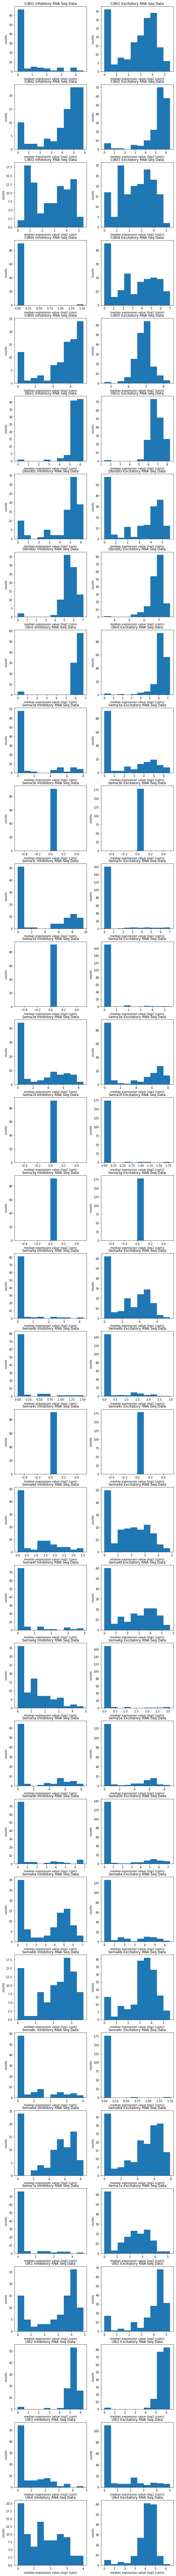

In [10]:
# exploratory analysis checking distributions of inhib and excitatory for each gene
# TODO: ylabel
num_genes = len(inhib_df)
fig, ax = plt.subplots(num_genes, 2, figsize=(10, 165))

for i in range(num_genes):
    # plot inhibitory data on left
    ax[i,0].hist(inhib_df.iloc[i][1:])
    ax[i,0].set_xlabel('median expression value (log2 (cpm)')
    ax[i,0].set_ylabel('counts')
    ax[i,0].set_title(inhib_df.loc[i][0] + ' Inhibitory RNA Seq Data')

    # plot excitatory data on right
    ax[i,1].hist(excit_df.iloc[i][1:])
    ax[i,1].set_xlabel('median expression value (log2 (cpm))')
    ax[i,1].set_ylabel('counts')
    ax[i,1].set_title(excit_df.loc[i][0] + ' Excitatory RNA Seq Data')

plt.show()

Looking at the distributions, we see that there are some genes with only 0.0 values. Since you cannot compare the same values in Mann-Whitney test, we get rid of those genes.

In [11]:
# get rid of the genes with 0.0 from the selected_genes list
removing = ['Sema3b', 'Sema3g', 'Sema4c']
for i in removing:
    selected_genes.remove(i)
    print(i)
    
print(selected_genes)

Sema3b
Sema3g
Sema4c
['Cdkl1', 'Cdkl2', 'Cdkl3', 'Cdkl4', 'Cdkl5', 'Dbn1', 'Dbndd1', 'Dbndd2', 'Dbnl', 'Sema3a', 'Sema3c', 'Sema3d', 'Sema3e', 'Sema3f', 'Sema4a', 'Sema4b', 'Sema4d', 'Sema4f', 'Sema4g', 'Sema5a', 'Sema5b', 'Sema6a', 'Sema6b', 'Sema6c', 'Sema6d', 'Sema7a', 'Ulk1', 'Ulk2', 'Ulk3', 'Ulk4']


In [28]:
# keep all the rows that do not have the genes with only '0.0' values in inhib_df and excit_df
inhib_df = inhib_df[inhib_df['Unnamed: 0'] != 'Sema3b']
inhib_df = inhib_df[inhib_df['Unnamed: 0'] != 'Sema3g']
inhib_df = inhib_df[inhib_df['Unnamed: 0'] != 'Sema4c'].reset_index().drop(columns='index')

excit_df = excit_df[excit_df['Unnamed: 0'] != 'Sema3b']
excit_df = excit_df[excit_df['Unnamed: 0'] != 'Sema3g']
excit_df = excit_df[excit_df['Unnamed: 0'] != 'Sema4c'].reset_index().drop(columns='index')

# update num_genes
num_genes = len(inhib_df)

After plotting the distributions of the genes for inhibitory neurons and exictatory neurons, we saw that almost all the populations are skewed. Therefore, we chose to run a Mann-Whitney test to compare the samples.

In [13]:
def manwhit_stats(index_of_gene):
    '''
    returns ttest results of exitatory df and inhib df of a gene at a specific index
    inputs: index number of gene
    '''
    return stats.mannwhitneyu(excit_df.iloc[index_of_gene][1:], inhib_df.iloc[index_of_gene][1:])   

In [14]:
mannwhit_results = dict()

for i in range(len(inhib_df)):
    gene_name = inhib_df['Unnamed: 0'][i]
    result_stats = manwhit_stats(i)
    mannwhit_results[gene_name] = result_stats

mannwhit_results

{'Cdkl1': MannwhitneyuResult(statistic=2872.0, pvalue=2.893544265740725e-19),
 'Cdkl2': MannwhitneyuResult(statistic=3786.0, pvalue=4.530937547843308e-13),
 'Cdkl3': MannwhitneyuResult(statistic=7813.0, pvalue=0.3181068479341936),
 'Cdkl4': MannwhitneyuResult(statistic=1988.0, pvalue=1.8158797466054293e-27),
 'Cdkl5': MannwhitneyuResult(statistic=3483.0, pvalue=1.0392446096614585e-14),
 'Dbn1': MannwhitneyuResult(statistic=769.0, pvalue=3.204189887081746e-34),
 'Dbndd1': MannwhitneyuResult(statistic=3504.0, pvalue=8.777553037750055e-15),
 'Dbndd2': MannwhitneyuResult(statistic=1053.0, pvalue=9.016674348694804e-32),
 'Dbnl': MannwhitneyuResult(statistic=6365.0, pvalue=0.002042882886585207),
 'Sema3a': MannwhitneyuResult(statistic=6527.0, pvalue=0.0018576779876655952),
 'Sema3c': MannwhitneyuResult(statistic=4990.0, pvalue=5.73477230947168e-13),
 'Sema3d': MannwhitneyuResult(statistic=7689.5, pvalue=0.014826313294100012),
 'Sema3e': MannwhitneyuResult(statistic=7857.0, pvalue=0.337396090

In [15]:
# highlight values that are below 0.05 (significance level)

for i in mannwhit_results.keys():
    pval = mannwhit_results[i][1]
    if pval < 0.05:
        print(i+ '; pval: '+str(pval))

Cdkl1; pval: 2.893544265740725e-19
Cdkl2; pval: 4.530937547843308e-13
Cdkl4; pval: 1.8158797466054293e-27
Cdkl5; pval: 1.0392446096614585e-14
Dbn1; pval: 3.204189887081746e-34
Dbndd1; pval: 8.777553037750055e-15
Dbndd2; pval: 9.016674348694804e-32
Dbnl; pval: 0.002042882886585207
Sema3a; pval: 0.0018576779876655952
Sema3c; pval: 5.73477230947168e-13
Sema3d; pval: 0.014826313294100012
Sema4a; pval: 6.307870729219536e-19
Sema4d; pval: 7.895128982162661e-08
Sema4f; pval: 6.294031254946503e-17
Sema4g; pval: 1.0359738105519828e-23
Sema6a; pval: 1.804868564200393e-11
Sema6b; pval: 2.8991727607335664e-14
Sema6c; pval: 2.512988968180287e-16
Sema7a; pval: 4.960811374659922e-15
Ulk1; pval: 9.411425445432194e-08
Ulk2; pval: 1.1560342768192409e-12
Ulk4; pval: 2.8046705437408185e-33


In the above listed genes with a significance level of 0.05, we found a significant difference in gene expression between inhibitory and excitatory neurons.

In [ ]:
figures_across = 6
fig, ax = plt.subplots(5, figures_across, figsize=(25,20),sharex=True)
y_label = 'med expression value (log2 (cpm))'
print(num_genes)

for i in range(num_genes):
    if i < figures_across:
        x_val = 0
        y_val = i
        
    elif i < (2*figures_across):
        x_val = 1
        y_val = i - (figures_across)
    
    elif i < (3*figures_across):
        x_val = 2
        y_val = i - (2*figures_across)
        
    elif i < (4*figures_across):
        x_val = 3
        y_val = i - (3*figures_across)
    
    elif i <= (5*figures_across):
        x_val = 4
        y_val = i - (4*figures_across)
    
    elif i == (6*figures_across):
        x_val = 4
        y_val = 5
    
    ax[x_val,y_val].boxplot(([inhib_df.loc[i][1:], excit_df.loc[i][1:]]))
    ax[x_val,y_val].set_title(inhib_df.loc[i][0])
    ax[x_val,y_val].set_ylabel(y_label)
    
plt.xticks([1,2],['inhibitory','excitatory'])
plt.show()

30


Pick some gene/gene families present in 

Picked from mouse genes that 
